# Embedding Extraction Tutorial
This notebook shows how to extract CXR Embeddings from the provided models

## Importing modules

This tutorial uses tensorflow-io to decode DICOM files. This step is entirely optional if you plan to use another module or to work on pre-processed data.

In [1]:
## Uncomment this line to install tensorflow-io. Please note that this will eventually upgrade your Python modules, including Tensorflow.
# !pip install -U tensorflow-io==0.16.0

In [2]:
import tensorflow as tf
import tensorflow_io as tfio # Used for decoding DICOM files
from tensorflow.keras.models import load_model # Used for loading the models
from tensorflow.keras.models import Model # Used to cut the Model
import matplotlib.pyplot as plt # Used to visualize the sample
import numpy as np # For pre-processing the sample

## Loading the model

This example uses the Xception architecture. The procedure for the other models is the same as shown here.

In [3]:
model = load_model('./models/Xception.hdf5')

The provided models contain a fully-connected layer for classification on the CheXpert Dataset:

In [4]:
model.output.shape

TensorShape([None, 14])

## Extracting the Embedding Layer

To generate the embeddings, create a new Keras Model by cutting the network at the GlobalAveragePooling2D layer.

In [5]:
embedding_output = model.get_layer('global_average_pooling2d').output 
embedding_model = Model(inputs=model.input, outputs=embedding_output)

The embeddings extracted by a Xception Model are vectors of 2048 elements:

In [6]:
embedding_model.output.shape

TensorShape([None, 2048])

## Data Loading and Preprocessing

This tutorial uses a DICOM file downloaded from the Tensorflow Repository: 
https://github.com/tensorflow/io/raw/master/docs/tutorials/dicom/dicom_00000001_000.dcm

In [7]:
# Downloading example DICOM
!curl -OL https://github.com/tensorflow/io/raw/master/docs/tutorials/dicom/dicom_00000001_000.dcm

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   164  100   164    0     0   2447      0 --:--:-- --:--:-- --:--:--  2447
100 1024k  100 1024k    0     0  7067k      0 --:--:-- --:--:-- --:--:-- 7067k


In [8]:
# Loading the DICOM file
image_bytes = tf.io.read_file('dicom_00000001_000.dcm')
# Decoding DICOM
image = tfio.image.decode_dicom_image(image_bytes, dtype=tf.float32)

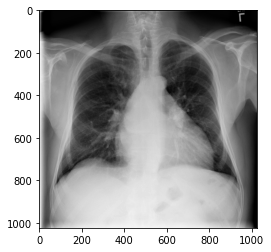

In [9]:
plt.imshow(image[0, ..., 0], cmap='gray')

The provided sample has shape (1024x1024x1). Our models have been trained using (224x224x3) images.
We reshape the image using a bilinear interpolation.

In [10]:
_, target_h, target_w, target_ch = embedding_model.input_shape
image_reshaped = tf.image.resize(image, [target_h, target_w]) # Resize to (224, 224, 1)
image_reshaped = tf.repeat(image_reshaped, [3], axis=-1) # Repeat the channel dimension.

Our dataset has been preprocessed using 224x224 images. 
First, we scaled each pixel to the [0, 1] range, then we applied ImageNet pre-processing.
Since the downloaded sample has range [0.0, 255.0] we can directly use the Keras Imagenet preprocessing function:

In [11]:
image_normalized = tf.keras.applications.imagenet_utils.preprocess_input(image_reshaped, mode='torch')

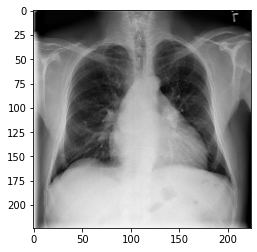

In [12]:
plt.imshow(image_normalized[0, ..., 0], cmap='gray')

## Generating the Embeddings
Now the model can be used to extract the embedding:

In [13]:
embedding = embedding_model.predict(image_normalized)
embedding.shape

(1, 2048)

The embedding can now be saved to a dataset, using either np.save or included in a Tensorflow Dataset.

### Visual Check
The embeddings can be reshaped and plotted to visualize their content.

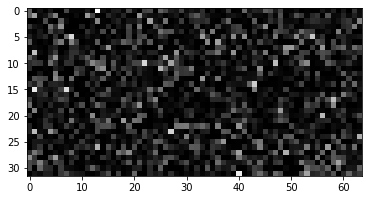

In [14]:
plt.imshow(np.reshape(embedding, (32, 64)), cmap='gray')